In [ ]:
!pip install reverse_geocoder

     |████████████████████████████████| 2.2 MB 34.4 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=f3abc96b72af59bc9aa56c59a159fd8ecb07a71f0f95160cbd3fc8ec58a7b32d
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder


In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import reverse_geocoder
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pickle
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
from psutil import virtual_memory
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_dir = "drive/MyDrive/Colab Notebooks/project/data/images/"
data_dir = "drive/MyDrive/Colab Notebooks/project/data/"
grid_path = "drive/MyDrive/Colab Notebooks/project/work/grid_coordinates.pkl"
model_path = "drive/MyDrive/Colab Notebooks/project/data/models/cnn_4_25_cnn_40epoch.pth"

### Get all coordinates and check which ones are in NY

In [ ]:
### Returns an array of True/False if the coordinate is in a given state
### coordinates: An array of coordinates
### state: Full name of the state. ex= "New York"
def get_coordinates_in_state(coordinates, state):
    coords = [(lat,long) for lat,long,ele in coordinates]
    results = reverse_geocoder.search(coords, mode=2)
    state = [x['admin1']==state for x in results]
    return state

In [ ]:
img_files = [f for f in listdir(img_dir) if isfile(join(img_dir, f))] # Names of all images in the folder
coordinates = loadmat(data_dir + "GPS_Long_Lat_Compass.mat")["GPS_Compass"] # Coordinates. Each coordinate corresponds to 6 pictures
in_ny = get_coordinates_in_state(coordinates=coordinates, state="New York") # All coordinates in NY
in_ny[:5]

Loading formatted geocoded file...


[False, False, False, False, False]

In [ ]:
len(coordinates)

10343

In [ ]:
print("Images: ", len(img_files))
print("Coordinates: ", len(coordinates))

Images:  62058
Coordinates:  10343


In [ ]:
in_ny_np = np.array(in_ny)
count = np.count_nonzero(in_ny_np)
print("Number of pictures in NY: ", count)
print("Total Pictures:", len(img_files))

Number of pictures in NY:  4731
Total Pictures: 62058


In [ ]:
### Orders the data as: [lattitude, longitude, direction], img_name
data = []
img_idx = 0;
ny_idx = 0;
for i in range(len(coordinates)):
    if in_ny[ny_idx]:
        data.append([coordinates[i],img_files[img_idx]])
        data.append([coordinates[i],img_files[img_idx+1]])
        data.append([coordinates[i],img_files[img_idx+2]])
        data.append([coordinates[i],img_files[img_idx+3]])
        data.append([coordinates[i],img_files[img_idx+4]])
        data.append([coordinates[i],img_files[img_idx+5]])
    ny_idx+=1
    img_idx+=6
    
data[:10]

[[array([ 40.74847 , -73.971083, 300.12    ]), '007353_4.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '007353_5.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '007354_0.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '007354_1.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '007354_2.jpg'],
 [array([ 40.74847 , -73.971083, 300.12    ]), '007354_3.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '007354_4.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '007354_5.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '007355_0.jpg'],
 [array([ 40.748518, -73.971197, 300.12    ]), '007355_1.jpg']]

In [ ]:
len(in_ny)

10343

In [ ]:
len(data)

28386

In [ ]:
### Orders data as [img_name, [lattitude, longitude, direction]]
data = [[d[1],d[0]] for d in data]
data[:5]

[['007353_4.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['007353_5.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['007354_0.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['007354_1.jpg', array([ 40.74847 , -73.971083, 300.12    ])],
 ['007354_2.jpg', array([ 40.74847 , -73.971083, 300.12    ])]]

In [ ]:
len(data)

28386

### Load classes that were created in ny_grid.ipynb

In [ ]:
### Load classifications from ny_grid.ipynb
with open(grid_path, 'rb') as f:
    grid_coordinates = pickle.load(f)

In [ ]:
grid_coordinates[:5]

[[array([ 40.714682, -74.013433]), 154],
 [array([ 40.714553, -74.013447]), 154],
 [array([ 40.714452, -74.013459]), 154],
 [array([ 40.714314, -74.013486]), 154],
 [array([ 40.714201, -74.013509]), 154]]

In [ ]:
### Match image and coordinates with grid classifcation
total_data = []
for i in range(len(data)):
    for j in range(len(grid_coordinates)):
        if grid_coordinates[j][0][0] == data[i][1][0] and grid_coordinates[j][0][1] == data[i][1][1]:
            data[i].append(grid_coordinates[j][1])

In [ ]:
data[:5]

[['007353_4.jpg', array([ 40.74847 , -73.971083, 300.12    ]), 339],
 ['007353_5.jpg', array([ 40.74847 , -73.971083, 300.12    ]), 339],
 ['007354_0.jpg', array([ 40.74847 , -73.971083, 300.12    ]), 339],
 ['007354_1.jpg', array([ 40.74847 , -73.971083, 300.12    ]), 339],
 ['007354_2.jpg', array([ 40.74847 , -73.971083, 300.12    ]), 339]]

In [ ]:
import pickle

with open(data_dir + 'data_with_grid.pkl', 'wb') as f:
    pickle.dump(data, f)

### Load Pre-Processed Data

In [ ]:
with open(data_dir + "data_with_grid.pkl", 'rb') as f:
    data = pickle.load(f)

### Create Custom Data Loader

In [ ]:
class Dataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None):
        self.root_dir = root_dir
        self.X = X
        self.y = y
        self.img_names = img_names
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.root_dir, self.img_names[index])).convert("RGB")
        y_label = self.y[index]

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
max([d[2] for d in data])

502

In [ ]:
transform = transforms.Compose(
    [
     transforms.Resize((1024,1280)),
    #  transforms.Resize((512, 640)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 16
img_names = [d[0] for d in data]
coordinates = [d[1] for d in data]
grid_loc = [d[2] for d in data]
num_classes = 630-1

X_train, X_test, y_train, y_test = train_test_split(img_names, grid_loc, test_size=0.33, random_state=42)

trainset = Dataset(X=X_train, y=y_train, root_dir=img_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

testset = Dataset(X=X_test, y=y_test, root_dir=img_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
classes = tuple(range(0,num_classes))

In [ ]:
print("Number of Pictures: ", len(img_names))

Number of Pictures:  28386


In [ ]:
print("Number of classes: ", len(classes)+1)

Number of classes:  630


In [ ]:
img, label = trainset[0]
print(img.shape,label)

torch.Size([3, 1024, 1280]) 401


### Display some images

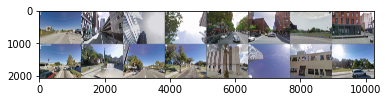

labels:  tensor([401, 218, 401, 340, 277, 188, 277, 309, 217, 185, 277, 184, 217, 187,
        187, 281])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: ", labels)

### Define Model

### Print Google Collab runtime settings


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 25 15:49:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
### CNN Model
### 273 minutes to train (4.55 hours)
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#         self.fc1 = nn.Linear(in_features=16 * 253 * 317, out_features=120) # Fully Connected Layers
#         self.fc2 = nn.Linear(in_features=120, out_features=84)
#         self.fc3 = nn.Linear(in_features=84, out_features=3774) # out_features is the number of classes
#         #LSTM
        

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# net.to(device)

In [ ]:
## CNN Model
## 273 minutes to train (4.55 hours)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*253*317, out_features=250) # Fully Connected Layers 16*253*317  
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)
        # self.fc3 = nn.Linear(in_features=1000, out_features=num_classes) # out_features is the number of classes
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        # outshape = tensorshape(self.conv1(x), 3)
        # print(outshape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1283216, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=629, bias=True)
)

In [ ]:
!pip install torchshape

In [ ]:
from torchshape import tensorshape



In [ ]:
### Half Sized Images
# ## CNN Model
# ## 273 minutes to train (4.55 hours)
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#         self.fc1 = nn.Linear(in_features=16* 128 * 160, out_features=250) # Fully Connected Layers 16*253*317  
#         self.fc2 = nn.Linear(in_features=250, out_features=num_classes)
#         # self.fc3 = nn.Linear(in_features=1000, out_features=num_classes) # out_features is the number of classes
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         # print(x.shape)
#         # outshape = tensorshape(self.conv1(x), 3)
#         # print(outshape)
#         x = self.pool(F.relu(self.conv2(x)))
#         # print(x.shape)
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         # print(x.shape)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x) # x = F.relu(self.fc2(x))
#         # x = self.fc3(x)
#         return x

# net = Net()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# net.to(device)

In [ ]:
# from torchvision.models import resnet18, resnet101
# ### LSTM With Resnet
# class CNNLSTM(nn.Module):
#     def __init__(self, num_classes=2):
#         super(CNNLSTM, self).__init__()
#         self.resnet = resnet101(pretrained=True)
#         self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 16 * 253 * 317))
#         self.lstm = nn.LSTM(input_size=16 * 253 * 317, hidden_size=256, num_layers=3)
#         self.fc1 = nn.Linear(256, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#     def forward(self, x_3d):
#         hidden = None
#         for t in range(x_3d.size(1)):
#             with torch.no_grad():
#                 x = self.resnet(x_3d[:, t, :, :])  
#             out, hidden = self.lstm(x.unsqueeze(0), hidden)         

#         x = self.fc1(out[-1, :, :])
#         x = F.relu(x)
#         x = self.fc2(x)
#         return x

# net = CNNLSTM()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# net.to(device)

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#         self.fc1 = nn.Linear(in_features=16 * 253 * 317, out_features=10000) # Fully Connected Layers
#         self.lstm = nn.LSTM(input_size=10000, hidden_size=5000, num_layers=3)
#         self.fc2 = nn.Linear(in_features=5000, out_features=4000)
#         self.fc3 = nn.Linear(in_features=4000, out_features=3774) # out_features is the number of classes

#     def forward(self, x_3d):
#         hidden = None
#         for t in range(x_3d.size(1)):
#             with torch.no_grad():
#                 x = self.resnet(x_3d[:, t, :, :, :])  
#             out, hidden = self.lstm(x.unsqueeze(0), hidden)         

#         x = self.fc1(out[-1, :, :])
#         x = F.relu(x)
#         x = self.fc2(x)
#         return x
        

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# net.to(device)

### Define Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the Model

In [ ]:
torch.cuda.empty_cache() #Clear GPU memory

In [ ]:
EPOCHS = 40
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    with tqdm(enumerate(trainloader,0), unit=" batch") as tepoch:
        for i, data in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(data)
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

print('Finished Training')

Epoch 0: : 1189 batch [1:03:51,  3.22s/ batch]
Epoch 1: : 1189 batch [13:17,  1.49 batch/s]
Epoch 2: : 1189 batch [13:20,  1.49 batch/s]
Epoch 3: : 1189 batch [13:21,  1.48 batch/s]
Epoch 4: : 1189 batch [13:22,  1.48 batch/s]
Epoch 5: : 1189 batch [13:24,  1.48 batch/s]
Epoch 6: : 1189 batch [13:26,  1.47 batch/s]
Epoch 7: : 1189 batch [13:26,  1.47 batch/s]
Epoch 8: : 1189 batch [13:27,  1.47 batch/s]
Epoch 9: : 1189 batch [13:26,  1.47 batch/s]
Epoch 10: : 1189 batch [13:29,  1.47 batch/s]
Epoch 11: : 1189 batch [13:27,  1.47 batch/s]
Epoch 12: : 1189 batch [13:28,  1.47 batch/s]
Epoch 13: : 1189 batch [13:27,  1.47 batch/s]
Epoch 14: : 1189 batch [13:28,  1.47 batch/s]
Epoch 15: : 1189 batch [13:27,  1.47 batch/s]
Epoch 16: : 1189 batch [13:26,  1.47 batch/s]
Epoch 17: : 1189 batch [13:25,  1.48 batch/s]
Epoch 18: : 1189 batch [13:26,  1.47 batch/s]
Epoch 19: : 372 batch [04:13,  1.48 batch/s]

In [ ]:
!pip install torch_utils

In [ ]:
# from torch_utils import AverageMeter, accuracy
# # from utils import accuracy
# train_loss = 0.0
# # losses = AverageMeter()
# # accuracies = AverageMeter()
# log_interval=2000
# epoch = 20
# for batch_idx, (data, targets) in enumerate(trainloader):
#     data, targets = data.to(device), targets.to(device)
#     outputs = net(data)

#     loss = criterion(outputs, targets)
#     acc = accuracy(outputs, targets)

#     train_loss += loss.item()
#     # losses.update(loss.item(), data.size(0))
#     # accuracies.update(acc, data.size(0))

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (batch_idx + 1) % log_interval == 0:
#         avg_loss = train_loss / log_interval
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch, (batch_idx + 1) * len(data), len(trainloader.dataset), 100. * (batch_idx + 1) / len(trainloader), avg_loss))
#         train_loss = 0.0

# print('Train set ({:d} samples): Training loss: {:.4f}'.format(len(trainloader.dataset), train_loss ))

### Save Trained Model


In [ ]:
torch.save(net.state_dict(), model_path)

### Display an image

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5d}' for j in range(4)))

### Load trained model

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
net = Net()
net.load_state_dict(torch.load(model_path))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5d}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
from tqdm import tqdm

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader):
        # print(data)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        outputs = outputs.to(device)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted[:len(labels)] == labels).sum().item()

print(f'Accuracy of the network on the {len(y_test)} test images: {100 * correct / total} %')

In [ ]:
100 * correct / total

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')  